## build an efficient spam detection system using machine learning
We will create a machine learning system capable of predicting whether a given email message matches a random email or not. To do this, we will use the TREC 2007 Spam Corpus as the dataset.

### DataSet
[Click here to visit the TREC 2007 Spam Corpus](https://plg.uwaterloo.ca/~gvcormac/treccorpus07/)

The corpus trec07p contains 75,419 messages:

            25220 ham
            50199 spam
            
            
These messages constitute all the messages delivered to a particular server between these dates:

        Sun, 8 Apr 2007 13:07:21 
        Fri, 6 Jul 2007 07:04:53 








In [65]:
import os
import email
import sklearn

dataset_path = r'C:\Users\Saif AbuDalo\Desktop\project\trec07p'
print(os.listdir(dataset_path))


['data', 'delay', 'full', 'partial', 'README.txt']


### We will focus on the Full and the data.


<p>Full &rarr; Index (Email classifications)</p>
<p>Data &rarr; Email</p>


### 1.Create the Labels Dictionary

In [66]:
DATA_DIR = r'C:\Users\Saif AbuDalo\Desktop\project\trec07p\data'
LABELS_FILE = r'C:\Users\Saif AbuDalo\Desktop\project\trec07p\full\index'


labels = {}

# Read the labels
with open(LABELS_FILE) as f:
    for line in f:  # Properly indented
        line = line.strip()  # Indent inside the loop
        label, key = line.split()
        labels[key.split('/')[-1]] = 1 if label.lower() == 'ham' else 0


#print(labels)

### Converting the Index File into a Dictionary

In this section, we will convert the **index file**, which contains email classifications (either **spam** or **ham**), into a dictionary. The index file contains entries that associate each email with a classification label and its corresponding file path.

Here’s an example of the content from the **index file**:

spam ../data/inmail.1
ham ../data/inmail.2
spam ../data/inmail.3
spam ../data/inmail.4
spam ../data/inmail.5|

Our goal is to transform this into a dictionary where:
- The **keys** are the filenames (e.g., `inmail.1`, `inmail.2`, etc.).
- The **values** represent the classification of the email: `1` for **ham** and `0` for **spam**.

The resulting dictionary will look like this:

```python
{'inmail.1': 0, 'inmail.2': 1, 'inmail.3': 0, 'inmail.4': 0, 'inmail.5': 0}


### 2.Create X and y

```python
X: list of string, each is the subject + body of the corresponding email
y: list of all labels (0:spam, 1:ham)


In [67]:
def read_email_files():
    X = []
    y = []
    for i in range(len(labels)):  # Loop through labels
        filename = f'inmail.{i+1}'  # Generate email filename
        # Extract subject and body text from a single email file
        email_path = os.path.join(DATA_DIR, filename)
        email_str = extract_email_text(email_path)  # Extract text from email
        X.append(email_str)  # Add email text to X
        y.append(labels[filename])  # Add corresponding label to y
    return X, y





In [68]:
def extract_email_text(path):
    """
    Extract the subject and body from an email file.
    """
    # Load a single email from an input file
    with open(path, 'r', errors='ignore') as f:
        # Read the email and store it in msg
        msg = email.message_from_file(f)
        if not msg: 
            return ""

        # Read the email subject
        subject = msg['Subject']
        if not subject: 
            subject = ""

        # Read the email body
        body = ' '.join(
            m for m in flatten_to_string(msg.get_payload()) if isinstance(m, str)
        )
        if not body: 
            body = ""

    # Return combined subject and body
    return f"{subject} {body}".strip()

In [69]:
def flatten_to_string(parts):
    ret = []
    
    # If part is a string, add it directly
    if isinstance(parts, str):
        ret.append(parts)
    
    # If part is a list, recursively process each item
    elif isinstance(parts, list):
        for part in parts:
            ret += flatten_to_string(part)
    
    # If the part's content type is 'text/plain', add its payload
    elif parts.get_content_type() == 'text/plain':
        ret += parts.get_payload()
    
    return ret


### Splitting Dataset

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, train_size=0.7, random_state=2)

### Splitting the Dataset into Training and Testing Sets

To train and evaluate our model effectively, we need to split the dataset into training and testing sets. The training set will be used to train the model, while the testing set will evaluate its performance on unseen data. 

In this code, we use `train_test_split` from the `sklearn.model_selection` module:
- `X`: The feature matrix containing the input data.
- `y`: The labels corresponding to each input (spam or ham).
- `train_size`: Specifies the proportion of data to be used for training (70% in this case).
- `random_state`: Ensures reproducibility by controlling the randomness of the split.

The output variables are:
- `X_train`: Training data features.
- `X_test`: Testing data features.
- `y_train`: Training data labels.
- `y_test`: Testing data labels.

Here is the implementation:


### Convert Raw Data To Feature Vector

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

### Feature Extraction Using CountVectorizer

In this section, we use the **CountVectorizer** from `sklearn.feature_extraction.text` to convert text data into numerical feature vectors. This transformation is essential for machine learning models to process textual data.

#### Key Steps:
1. **`CountVectorizer`**:
   - Converts a collection of text documents into a matrix of token counts.
   - Each column in the matrix corresponds to a unique word from the dataset.
   - The values represent the frequency of the word in the corresponding document.

2. **Training and Testing Vectors**:
   - `fit_transform(X_train)`: Fits the vectorizer on the training data and transforms it into a sparse matrix of token counts.
   - `transform(X_test)`: Transforms the test data into the same feature space without refitting, ensuring consistency between training and testing data.



### Naive Bayes Classification

In [72]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
# Initialize the classifier and make label predictions
mnb = MultinomialNB()
mnb.fit(X_train_vector, y_train)
y_pred = mnb.predict(X_test_vector)
# Print results
print('Accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))

Accuracy 99.7%


### Training and Evaluating a Multinomial Naive Bayes Classifier

In this section, we use the **Multinomial Naive Bayes (MNB)** algorithm to train a classifier for spam detection and evaluate its performance.

#### Key Steps:

1. **Multinomial Naive Bayes**:
   - A probabilistic classifier that works well for discrete data like text word counts.
   - Based on Bayes' theorem with an assumption of feature independence.

2. **Training**:
   - The model is trained on the vectorized training data (`X_train_vector`) with corresponding labels (`y_train`).

3. **Prediction**:
   - The trained model is used to predict the labels (`y_pred`) for the test data (`X_test_vector`).

4. **Evaluation**:
   - The `accuracy_score` metric is used to measure the percentage of correctly classified emails.



### perform different experiments using different data Splits for training and testing sets:
(80:20), (60:40), (50:50), (40:60), (20:80).

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Initialize a list of splits
splits = [0.8, 0.6, 0.5, 0.4, 0.2]

# Initialize a vectorizer
vectorizer = CountVectorizer()

# Iterate over each split
for split in splits:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split, random_state=2)
    
    # Vectorize the data
    X_train_vector = vectorizer.fit_transform(X_train)
    X_test_vector = vectorizer.transform(X_test)
    
    # Train the Naive Bayes classifier
    mnb = MultinomialNB()
    mnb.fit(X_train_vector, y_train)
    
    # Predict on the test set
    y_pred = mnb.predict(X_test_vector)
    
    # Evaluate and print the results
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Train:Test Split = {int(split * 100)}:{int((1 - split) * 100)} -> Accuracy: {accuracy:.2%}")


Train:Test Split = 80:19 -> Accuracy: 99.70%
Train:Test Split = 60:40 -> Accuracy: 99.72%
Train:Test Split = 50:50 -> Accuracy: 99.72%
Train:Test Split = 40:60 -> Accuracy: 99.74%
Train:Test Split = 20:80 -> Accuracy: 99.68%


# Visualization of Model Accuracy Across Different Train-Test Splits

In this section, we will analyze the impact of various train-test splits on the model's accuracy. The splits used are:

- 80:20
- 60:40
- 50:50
- 40:60
- 20:80

The model's accuracy for each split is plotted to observe any trends or variations.

### Code to Compare and Visualize Results


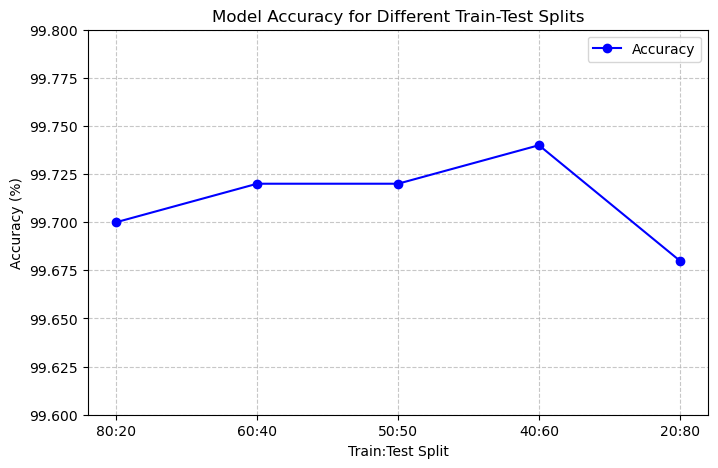

In [75]:
import matplotlib.pyplot as plt

# Train-Test Splits and Corresponding Accuracies
splits = ['80:20', '60:40', '50:50', '40:60', '20:80']
accuracies = [99.70, 99.72, 99.72, 99.74, 99.68]  # Replace with your exact values if needed

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(splits, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('Model Accuracy for Different Train-Test Splits')
plt.xlabel('Train:Test Split')
plt.ylabel('Accuracy (%)')
plt.ylim(99.6, 99.8)  # Adjust based on your accuracy range
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


### Insights from the Chart

1. **Trend Observation**: The accuracy values are stable across different train-test splits, with slight improvements at specific splits.
2. **Optimal Split**: The highest accuracy (99.74%) is observed with the 40:60 split.
3. **Model Robustness**: The small variation in accuracy (99.68% to 99.74%) highlights the model's consistency across different data splits.

This visualization helps in understanding the trade-offs and stability of the model when trained with varying amounts of data.


## Saif Abu-Dalo